In [38]:
from importlib import reload
import sys
import pickle
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib inline
import seaborn as sns
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pybedtools
from joblib import Parallel, delayed
from tqdm import tqdm
import time
from matplotlib_venn import venn3
from upsetplot import from_contents, UpSet
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import pdist, squareform
from umap import UMAP

# Data directories

In [2]:
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

In [71]:
genome_dir = '/home/braunger/masterthesis/data/genome_data/'
epigenome_dir = '/home/braunger/masterthesis/data/regulatory_data/regulatory_data_'+cell_type+'/'
processed_epigenome_data_dir = '/home/braunger/masterthesis/save/processed_regulatory_marks/processed_epigenome_data_'+cell_type+'/'
processed_hic_data_dir = '/home/braunger/masterthesis/save/processed_hic_data/processed_hic_data_'+cell_type+'/final_BP250000_intraKR_interINTERKR/'
PCs_dir = '/home/braunger/masterthesis/save/processed_hic_data/processed_hic_data_'+cell_type+'/intrachromosomal_PCs/'
save_dir = '/home/braunger/masterthesis/save/figures/active_loci_clustering_'+cell_type+'/'
active_loci_dir = '/home/braunger/masterthesis/save/active_loci/'

# Determine active and inactive regions

### Load epigenomic data

In [4]:
# Helper function for loading principal component data
def get_PCs(PCs_dir, chrom, df_chipseq_norm):
    # load PCs
    PCs = pd.read_csv(PCs_dir+'PCs_chr'+str(chrom)+'.csv', header=0, index_col = 0)
    
    # calculate correlation of the two PCs to the RNA-seq
    corr_PC1 = np.corrcoef(PCs.iloc[:, 0], df_chipseq_norm.loc['RNAseq'])[0,1]
    corr_PC2 = np.corrcoef(PCs.iloc[:, 1], df_chipseq_norm.loc['RNAseq'])[0,1]
    
    # choose between PC1 and PC2 the one with higher correlation and correct to positive correlation with RNA-seq
    if abs(corr_PC1) >= abs(corr_PC2):
        if corr_PC1 < 0:
            PC = -1 * PCs.iloc[:, 0]
        else:
            PC = PCs.iloc[:, 0]
    else:
        if corr_PC2 < 0:
            PC = -1 * PCs.iloc[:, 1]
        else:
            PC = PCs.iloc[:, 1]

    
    # create pd DataFrame
    PC = pd.DataFrame(PC).T
    PC.index = ["PC"]
    PC.columns = df_chipseq_norm.columns
    return(PC)

In [5]:
# collect normalized epigenomic data across all chromosomes into one dataframe
df_all_norm = pd.DataFrame()
chr_list =  np.arange(1,22+1)
for chrom in chr_list:
    # get feature matrix per chromosome
    df_chipseq_norm = pd.read_csv(processed_epigenome_data_dir+'features_matrix_chr'+str(chrom)+'_norm.csv', header=0, index_col = 0)
    df_chipseq_norm.columns = 'chr_'+str(chrom)+'_loc_'+np.array(df_chipseq_norm.columns)
    # get PCs on intrachromosomal hic data
    PC = get_PCs(PCs_dir, chrom, df_chipseq_norm)
    # add PC as feature
    df_chipseq_complete = pd.concat([df_chipseq_norm, PC], axis = 0)
    # Concatenate to data for previous chromosomes
    df_all_norm = pd.concat([df_all_norm, df_chipseq_complete],axis=1)

### Correlation between features

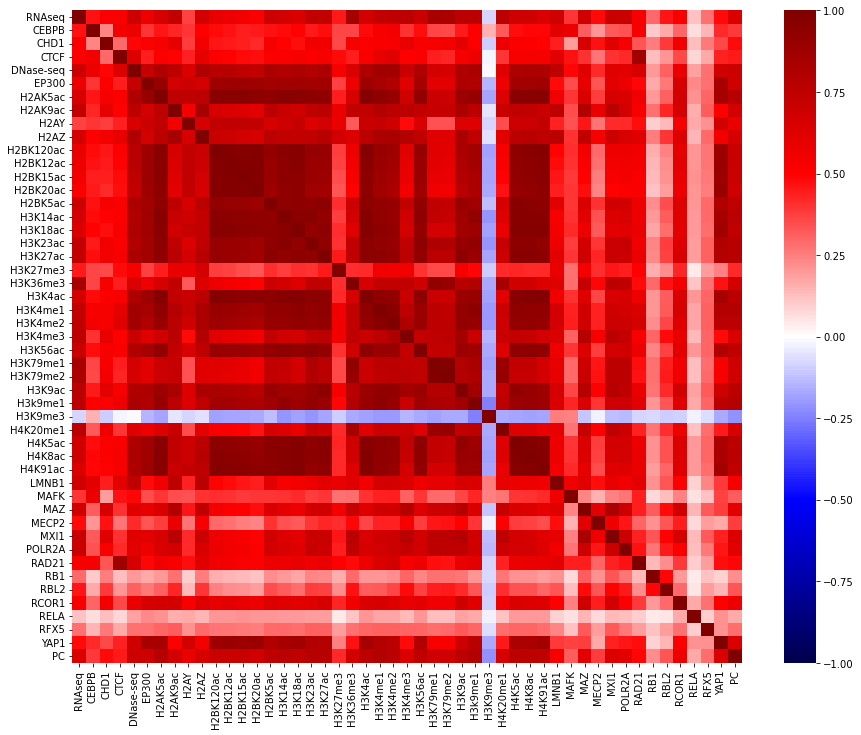

In [6]:
plt.figure(figsize = (15,12))
sns.heatmap(df_all_norm.T.corr(), cmap = "seismic", vmin = -1, vmax = 1)
plt.savefig(save_dir+'feature_correlations.png')
plt.show()

In [7]:
df_all_norm.T.corr().loc["RNAseq", "PC"]

0.6421189359968067

### Correlations of PCs to RNA-seq

In [55]:
for chrom in chr_list:
    PCs = pd.read_csv(PCs_dir+'PCs_chr'+str(chrom)+'.csv', header=0, index_col = 0)

    #Calculate correlation of PCs to RNA-seq
    RNA_all = df_all_norm.loc['RNAseq']
    RNA_chrom = np.array(RNA_all[RNA_all.index.str.contains('chr_'+str(chrom)+'_')])
    corr_PC1 = np.corrcoef(PCs.iloc[:, 0], RNA_chrom)[0,1]
    corr_PC2 = np.corrcoef(PCs.iloc[:, 1], RNA_chrom)[0,1]

    print("Correlation between RNA-seq and PC1 on chrom "+str(chrom)+": "+str(corr_PC1))
    print("Correlation between RNA-seq and PC2 on chrom "+str(chrom)+": "+str(corr_PC2))
    print()

Correlation between RNA-seq and PC1 on chrom 1: 0.7474436677039412
Correlation between RNA-seq and PC2 on chrom 1: 0.028992095301264717

Correlation between RNA-seq and PC1 on chrom 2: 0.6609239952348495
Correlation between RNA-seq and PC2 on chrom 2: -0.1504131878461155

Correlation between RNA-seq and PC1 on chrom 3: 0.6857664793661439
Correlation between RNA-seq and PC2 on chrom 3: 0.23891624990664254

Correlation between RNA-seq and PC1 on chrom 4: 0.6223263105791578
Correlation between RNA-seq and PC2 on chrom 4: -0.2703082498051376

Correlation between RNA-seq and PC1 on chrom 5: 0.7031140215254955
Correlation between RNA-seq and PC2 on chrom 5: 0.12230103027929722

Correlation between RNA-seq and PC1 on chrom 6: 0.57507738157015
Correlation between RNA-seq and PC2 on chrom 6: 0.3077448517941328

Correlation between RNA-seq and PC1 on chrom 7: 0.6145664047271777
Correlation between RNA-seq and PC2 on chrom 7: 0.3577246822952664

Correlation between RNA-seq and PC1 on chrom 8: 0.6

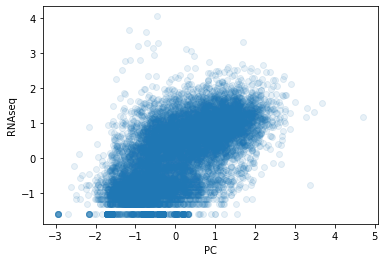

In [62]:
plt.figure()
plt.scatter(df_all_norm.T['PC'], df_all_norm.T['RNAseq'], alpha = 0.1)
plt.xlabel('PC')
plt.ylabel('RNAseq')
plt.show()

### Cophenetic Correlation with cosine metric

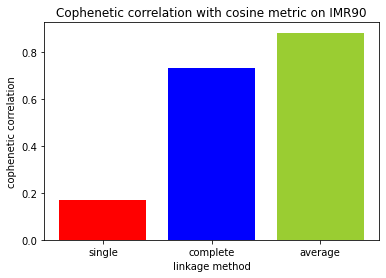

0.8826271711423692


In [80]:
distances = pdist(df_all_norm.T, metric = "cosine")
# Check which is the best technique in terms of cophenetic correlation
cophenet_single = cophenet(linkage(distances, method='single'), distances)[0]
cophenet_complete = cophenet(linkage(distances, method='complete'), distances)[0]
cophenet_average = cophenet(linkage(distances, method='average'), distances)[0]

plt.figure()
plt.bar(x=['single', 'complete', 'average'],
        height = [cophenet_single, cophenet_complete, cophenet_average],
        color = ['red', 'blue', 'yellowgreen'])
plt.xlabel('linkage method')
plt.ylabel('cophenetic correlation')
plt.title('Cophenetic correlation with cosine metric on IMR90')
plt.savefig(save_dir+'cophenetic_correlation_cosine.png')
plt.show()
print(cophenet_average)

### Cophenetic Correlation with correlation metric

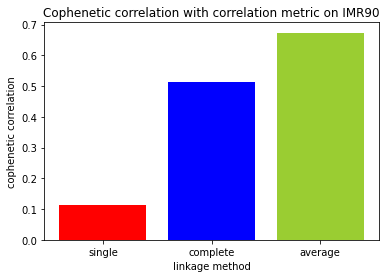

In [64]:
distances_corr = pdist(df_all_norm.T, metric = "correlation")
# Check which is the best technique in terms of cophenetic correlation
cophenet_single_corr = cophenet(linkage(distances_corr, method='single'), distances_corr)[0]
cophenet_complete_corr = cophenet(linkage(distances_corr, method='complete'), distances_corr)[0]
cophenet_average_corr = cophenet(linkage(distances_corr, method='average'), distances_corr)[0]

plt.figure()
plt.bar(x=['single', 'complete', 'average'],
        height = [cophenet_single_corr, cophenet_complete_corr, cophenet_average_corr],
        color = ['red', 'blue', 'yellowgreen'])
plt.xlabel('linkage method')
plt.ylabel('cophenetic correlation')
plt.title('Cophenetic correlation with correlation metric on IMR90')
plt.savefig(save_dir+'cophenetic_correlation_correlation.png')
plt.show()

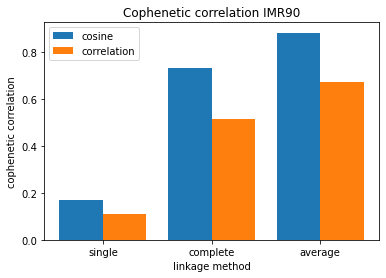

In [65]:
x = np.arange(3)
plt.figure()
plt.bar(x-0.2, height = [cophenet_single, cophenet_complete, cophenet_average], width = 0.4)
plt.bar(x+0.2, height = [cophenet_single_corr, cophenet_complete_corr, cophenet_average_corr], width = 0.4)
plt.xticks(x, ['single', 'complete', 'average'])
plt.xlabel('linkage method')
plt.ylabel('cophenetic correlation')
plt.title('Cophenetic correlation IMR90')
plt.legend(["cosine", "correlation"])
plt.savefig(save_dir+'cophenetic_correlation.png')
plt.show()

### Hierarchical clustering

In [43]:
# Using all features
# Correlation as affinity
clustering_corr = AgglomerativeClustering(n_clusters=2, affinity='correlation', linkage='average').fit(df_all_norm.T)
# Cosine as affinity
clustering_cos = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='average').fit(df_all_norm.T)

print('Total number of loci = '+str(len(clustering_cos.labels_)))
print('Number of loci in cluster 0 = '+str(np.sum(clustering_cos.labels_==0)))
print('Number of loci in cluster 1 = '+str(np.sum(clustering_cos.labels_==1)))
print('Percentage of loci in the active cluster (0) = '+str(np.sum(clustering_cos.labels_==0)/len(clustering_cos.labels_)*100)+'%.')

Total number of loci = 11537
Number of loci in cluster 0 = 6030
Number of loci in cluster 1 = 5507
Percentage of loci in the active cluster (0) = 52.26662043858889%.


In [53]:
# Using all features but PC
df_without_PC = df_all_norm.drop("PC")
# Correlation as affinity
clustering_corr_wo_PC = AgglomerativeClustering(n_clusters=2, affinity='correlation', linkage='average').fit(df_without_PC.T)
# Cosine as affinity
clustering_cos_wo_PC = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='average').fit(df_without_PC.T)

In [74]:
# Using only RNAseq
RNA = pd.DataFrame(df_all_norm.T["RNAseq"])
# Correlation as affinity
#clustering_corr_RNA = AgglomerativeClustering(n_clusters=2, affinity='correlation', linkage='average').fit(RNA)
# Cosine as affinity
clustering_cos_RNA = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='average').fit(RNA)

In [75]:
RNA

,RNAseq
chr_1_loc_0,-0.450589
chr_1_loc_250000,-0.822991
chr_1_loc_500000,0.516222
chr_1_loc_750000,1.684496
chr_1_loc_1000000,1.991869
...,...
chr_22_loc_50250000,1.199065
chr_22_loc_50500000,1.533346
chr_22_loc_50750000,1.382589
chr_22_loc_51000000,0.904141


In [27]:
# Add cluster to data
df_clusters = df_all_norm.T
df_clusters['cluster_corr_all'] = clustering_corr.labels_
df_clusters['cluster_cos_all'] = clustering_cos.labels_
df_clusters['cluster_corr_wo_PC'] = clustering_corr_wo_PC.labels_
df_clusters['cluster_cos_wo_PC'] = clustering_cos_wo_PC.labels_
df_clusters['cluster_cos_RNA'] = clustering_cos_RNA.labels_

### Plot histogram of RNAseq in clusters to determine the active cluster

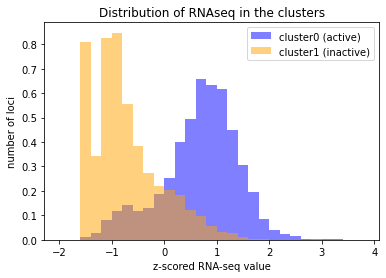

In [28]:
# Cosine affinity
%matplotlib inline
plt.figure()
plt.hist(df_clusters.loc[df_clusters['cluster_cos_all']==0]['RNAseq'], bins=np.arange(-2,4,0.2), 
         color='blue', alpha=0.5, density=True, label='cluster0 (active)')
plt.hist(df_clusters.loc[df_clusters['cluster_cos_all']==1]['RNAseq'], bins=np.arange(-2,4,0.2), 
         color='orange', alpha=0.5, density=True, label='cluster1 (inactive)')
plt.xlabel('z-scored RNA-seq value')
plt.ylabel('number of loci')
plt.title('Distribution of RNAseq in the clusters')
plt.legend(loc='upper right')
plt.savefig(save_dir+'RNAseq_cos_all.png')
plt.show()

### Overlap of loci in the active cluster

In [29]:
active_loci_corr_all = df_clusters[df_clusters["cluster_corr_all"] == 1].index.tolist()
active_loci_cos_all = df_clusters[df_clusters["cluster_cos_all"] == 0].index.tolist()
active_loci_corr_wo_PC = df_clusters[df_clusters["cluster_corr_wo_PC"] == 1].index.tolist()
active_loci_cos_wo_PC = df_clusters[df_clusters["cluster_cos_wo_PC"] == 0].index.tolist()
active_loci_cos_RNA = df_clusters[df_clusters["cluster_cos_RNA"] == 0].index.tolist()

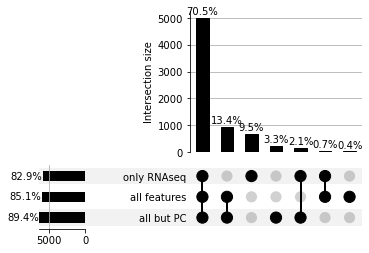

In [30]:
intersections = from_contents({'all features': active_loci_cos_all, 
                               'all but PC': active_loci_cos_wo_PC,
                               'only RNAseq': active_loci_cos_RNA})
upset = UpSet(intersections, subset_size='count', show_percentages = True, 
              sort_by="cardinality").plot()

plt.savefig(save_dir+'intersections.png')

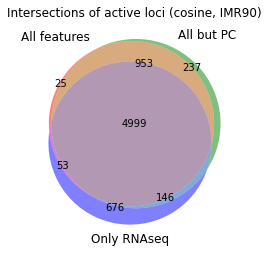

In [31]:
venn3(subsets = [set(active_loci_cos_all), set(active_loci_cos_wo_PC), set(active_loci_cos_RNA)], 
      set_labels = ('All features', 'All but PC', 'Only RNAseq'), alpha = 0.5)
plt.title("Intersections of active loci (cosine, IMR90)")
plt.savefig(save_dir+'venn_cosine.png')

### Feature heatmap

<Figure size 432x288 with 0 Axes>

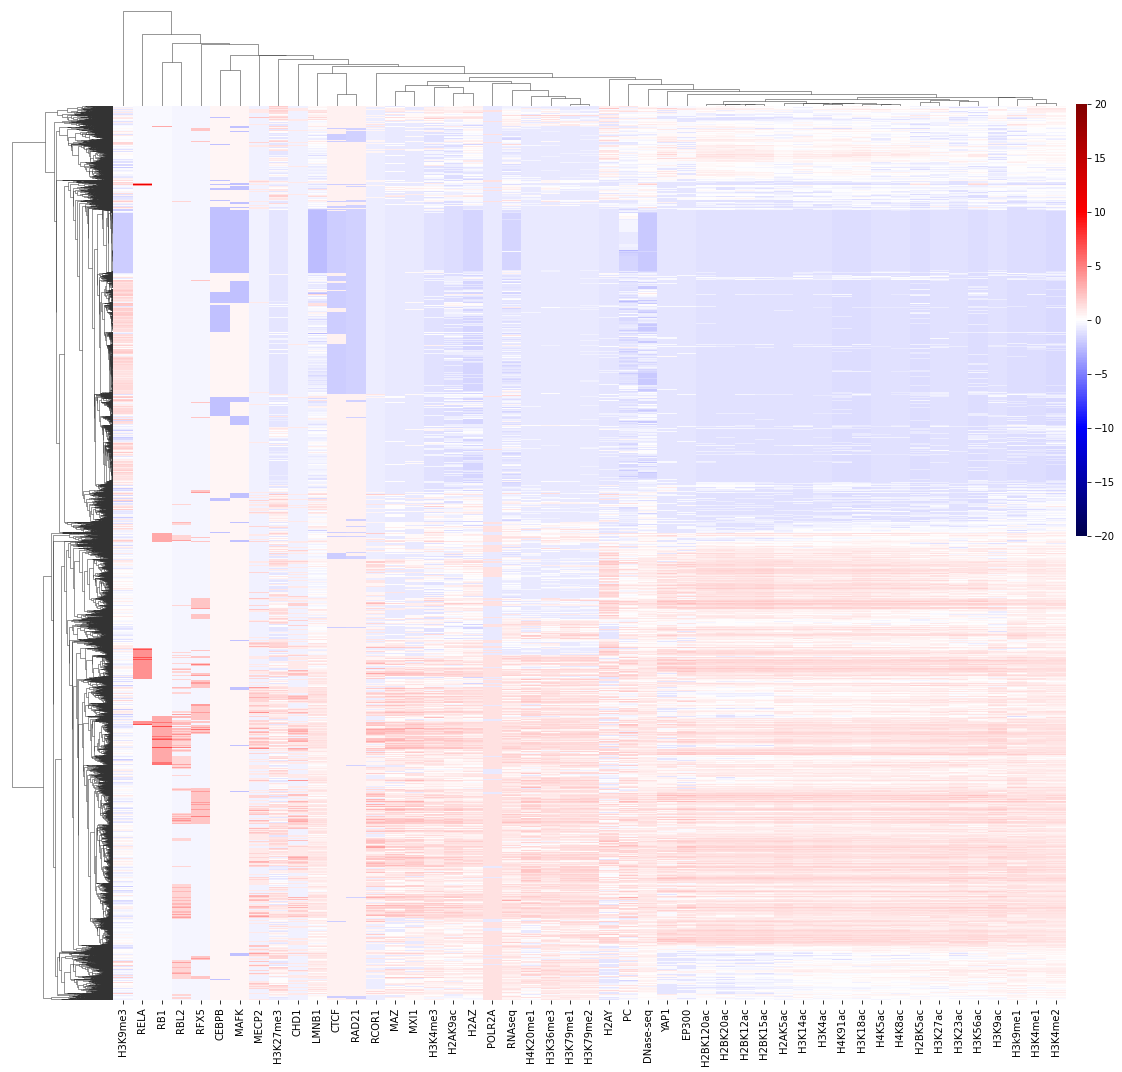

In [32]:
plt.figure()
sns.clustermap(df_all_norm.T,
               method='average',
               metric='cosine',
               row_cluster=True, col_cluster=True,
               figsize=(15,15),
               xticklabels=True, yticklabels=False,
               cmap='seismic', cbar_pos=(1, 0.5, 0.01, .4),
               vmin=-20, vmax=20,
               dendrogram_ratio=(.1, .1))
plt.savefig(save_dir+'feature_heatmap.png')
plt.show()

### tSNE

In [36]:
# tSNE
tSNE = TSNE(n_components=2)
tSNE_components = tSNE.fit_transform(df_all_norm.T)

# Add tSNE to data
df_clusters['tSNE1'] = tSNE_components[:,0]
df_clusters['tSNE2'] = tSNE_components[:,1]
df_clusters.head()

/home/braunger/miniconda3/envs/hic/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/braunger/miniconda3/envs/hic/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,RNAseq,CEBPB,CHD1,CTCF,DNase-seq,EP300,H2AK5ac,H2AK9ac,H2AY,H2AZ,...,RFX5,YAP1,PC,cluster_corr_all,cluster_cos_all,cluster_corr_wo_PC,cluster_cos_wo_PC,cluster_cos_RNA,tSNE1,tSNE2
chr_1_loc_0,-0.450589,-2.409666,-0.599723,0.513051,-1.289208,-0.975272,-1.147463,-1.303198,-0.525436,-1.573201,...,-0.376043,-1.034528,-1.587953,0,1,0,1,1,-9.569832,-42.249596
chr_1_loc_250000,-0.822991,-2.409666,-0.599723,-1.949124,-2.080191,-0.975272,-1.147463,-1.303198,-1.037812,-1.573201,...,-0.376043,-1.034528,-1.591216,0,1,0,1,1,-61.387886,-20.347727
chr_1_loc_500000,0.516222,0.414995,-0.599723,0.513051,0.479603,-0.975272,-0.522315,-1.303198,-1.037812,-0.392888,...,-0.376043,-1.034528,-1.514247,0,1,0,1,0,18.688419,22.564180
chr_1_loc_750000,1.684496,0.414995,3.951516,0.513051,1.109926,1.572444,1.400294,2.463924,0.963985,1.993937,...,-0.376043,-1.034528,0.701050,0,0,0,0,0,57.340908,4.298560
chr_1_loc_1000000,1.991869,0.414995,3.321871,0.513051,0.660545,1.177798,1.400294,2.451165,1.212706,1.757557,...,-0.376043,-0.229470,0.431403,0,0,0,0,0,57.465961,4.614631


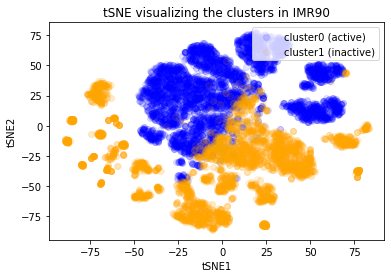

In [51]:
# Plot tSNE1 and tSNE2
plt.figure()
plt.scatter(df_clusters[df_clusters['cluster_cos_all']==0]['tSNE1'], 
            df_clusters[df_clusters['cluster_cos_all']==0]['tSNE2'], 
            c='blue', label = 'cluster0 (active)', alpha=0.1)
plt.scatter(df_clusters[df_clusters['cluster_cos_all']==1]['tSNE1'], 
            df_clusters[df_clusters['cluster_cos_all']==1]['tSNE2'], 
            c='orange', label = 'cluster1 (inactive)', alpha=0.1)
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.legend(loc='upper right')
plt.title('tSNE visualizing the clusters in IMR90')
plt.savefig(save_dir+'tSNE.png')
plt.show()

### UMAP

In [39]:
umap = UMAP(n_components = 2).fit_transform(df_all_norm.T)
# Add UMAP to data
df_clusters['UMAP1'] = umap[:,0]
df_clusters['UMAP2'] = umap[:,1]
df_clusters.head()

,RNAseq,CEBPB,CHD1,CTCF,DNase-seq,EP300,H2AK5ac,H2AK9ac,H2AY,H2AZ,...,PC,cluster_corr_all,cluster_cos_all,cluster_corr_wo_PC,cluster_cos_wo_PC,cluster_cos_RNA,tSNE1,tSNE2,UMAP1,UMAP2
chr_1_loc_0,-0.450589,-2.409666,-0.599723,0.513051,-1.289208,-0.975272,-1.147463,-1.303198,-0.525436,-1.573201,...,-1.587953,0,1,0,1,1,-9.569832,-42.249596,5.044105,5.160177
chr_1_loc_250000,-0.822991,-2.409666,-0.599723,-1.949124,-2.080191,-0.975272,-1.147463,-1.303198,-1.037812,-1.573201,...,-1.591216,0,1,0,1,1,-61.387886,-20.347727,14.248629,12.180427
chr_1_loc_500000,0.516222,0.414995,-0.599723,0.513051,0.479603,-0.975272,-0.522315,-1.303198,-1.037812,-0.392888,...,-1.514247,0,1,0,1,0,18.688419,22.564180,-1.752205,6.095413
chr_1_loc_750000,1.684496,0.414995,3.951516,0.513051,1.109926,1.572444,1.400294,2.463924,0.963985,1.993937,...,0.701050,0,0,0,0,0,57.340908,4.298560,-9.607522,6.527589
chr_1_loc_1000000,1.991869,0.414995,3.321871,0.513051,0.660545,1.177798,1.400294,2.451165,1.212706,1.757557,...,0.431403,0,0,0,0,0,57.465961,4.614631,-9.578958,6.490696


<Figure size 432x288 with 0 Axes>

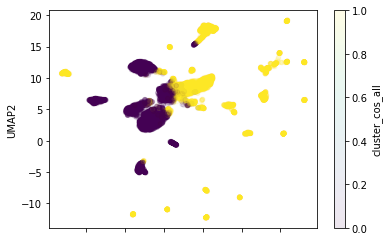

In [42]:
# Plot UMAP1 and UMAP2
plt.figure()
df_clusters.plot.scatter(x='UMAP1', y='UMAP2', c='cluster_cos_all', colormap='viridis', alpha=0.1)
plt.show()

### Save list of active loci

In [82]:
pd.DataFrame(active_loci_cos_all).to_csv(active_loci_dir+cell_type+'_cosine_all_features.txt', index = False)
pd.DataFrame(active_loci_cos_wo_PC).to_csv(active_loci_dir+cell_type+'_cosine_wo_PC.txt', index = False)